In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.pricer.monte_carlo_pricer import*

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Lets confirm the convexity profile of var swaps. The convex profile of var swaps demands a premium to vol swaps.

In [2]:
# Didnt really have to store variables this way..just for kicks.
params = {
    "vega": 5000.,
    "strike": 0.20,
    "T": 252.,
    "S": 100.,
    "r": 0.01
}

In [3]:
MC = MCPricer(params['S'], params['r'],"normal", T=params['T'])

Initialized MC Pricer


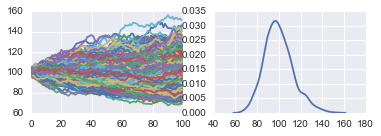

In [4]:
# Simulate some paths
MC.simulate(1000, 100, params['strike'])
episodes = MC.episodes
plt.figure(1)
plt.subplot(221)
[plt.plot(episode) for episode in episodes]
plt.subplot(222)
sns.kdeplot(episodes[:, -1])

In [5]:
df = pd.DataFrame(episodes).T
df = np.log(df/df.shift(1)).dropna()

# Variance is additive so just sum the squared log returns along the path. As usual we are assuming a mean variance
# of zero as an approximation.
sigma2 = lambda col: 10000*252*np.cumsum(col**2)/np.arange(len(col))
df = df.apply(sigma2)[1:]

series = df.tail(1).T
series['vol'] = np.sqrt(series)
series.rename(columns={99: 'var'}, inplace=True)

# Strikes are stored as decimals (e.g 0.20 as opposed to 20) thus need to rescale by 100
series['var_pnl'] = (series['var'] - (params['strike']*100)**2) * (params['vega']/(2.*(params['strike']*100)))
series['vol_pnl'] = (series['vol'] - (params['strike']*100)) * (params['vega'])

series.tail()

,var,vol,var_pnl,vol_pnl
995,450.061570,21.214655,6257.696298,6073.273069
996,400.808239,20.020196,101.029929,100.978946
997,390.840144,19.769677,-1144.981953,-1151.613015
998,363.890668,19.075919,-4513.666453,-4620.407269
999,358.993312,18.947119,-5125.836002,-5264.405847


In [6]:
series.index = series['vol']
del series['var']
del series['vol']


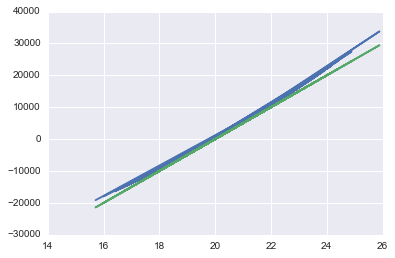

In [7]:
plt.plot(series)

We can confirm the convexity of variance swaps compared to vol swaps. A var swap wont lose as much when realized var is below the strike, while when realized volatility is above the strike, var swaps generate larger profit relatively.